In [222]:
import pandas as pd

file_path = 'C:/Users/Gasper/OneDrive - Univerza v Ljubljani/IJS/e5/data/Train_Test_IoT_Fridge.csv'
df = pd.read_csv(file_path, delimiter='\t')  
df = pd.read_csv(file_path, encoding='utf-8-sig')  
df

,ts,date,time,fridge_temperature,temp_condition,label,type
0,1556245180,25-Apr-19,19:19:40,9.00,high,1,ddos
1,1556245180,25-Apr-19,19:19:40,9.25,high,1,ddos
2,1556245185,25-Apr-19,19:19:45,12.65,high,1,ddos
3,1556245185,25-Apr-19,19:19:45,4.65,low,1,ddos
4,1556245195,25-Apr-19,19:19:55,12.65,high,1,ddos
...,...,...,...,...,...,...,...
59939,1554203235,2-Apr-19,04:07:15,7.65,high,0,normal
59940,1554203235,2-Apr-19,04:07:15,13.85,high,0,normal
59941,1554203235,2-Apr-19,04:07:15,5.40,low,0,normal
59942,1554203235,2-Apr-19,04:07:15,2.90,low,0,normal


In [223]:
import pandas as pd

file_path = 'C:/Users/Gasper/OneDrive - Univerza v Ljubljani/IJS/e5/data/Train_Test_IoT_Fridge.csv'
df_shuffled = pd.read_csv(file_path, delimiter='\t')  
df_shuffled = pd.read_csv(file_path, encoding='utf-8-sig')  
df_shuffled = df_shuffled.sample(frac=1).reset_index(drop=True) # Shuffle rows
df_shuffled

,ts,date,time,fridge_temperature,temp_condition,label,type
0,1554061242,31-Mar-19,12:40:42,11.00,high,0,normal
1,1556206618,25-Apr-19,08:36:58,12.40,high,1,injection
2,1554061174,31-Mar-19,12:39:34,6.85,high,0,normal
3,1556205631,25-Apr-19,08:20:31,4.45,low,1,injection
4,1556524434,29-Apr-19,0:53:54,7.10,high,1,backdoor
...,...,...,...,...,...,...,...
59939,1554061382,31-Mar-19,12:43:02,10.95,high,0,normal
59940,1554061205,31-Mar-19,12:40:05,10.85,high,0,normal
59941,1554061359,31-Mar-19,12:42:39,9.65,high,0,normal
59942,1556451203,28-Apr-19,04:33:23,8.65,high,1,ransomware


In [224]:
min_value = df_shuffled['fridge_temperature'].min()
max_value = df_shuffled['fridge_temperature'].max()

print(f"Minimum value of fridge_temperature: {min_value}")
print(f"Maximum value of fridge_temperature: {max_value}")

Minimum value of fridge_temperature: 1.0
Maximum value of fridge_temperature: 14.0


In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Remove leading and trailing whitespace from all string columns
df_shuffled = df_shuffled.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Label encoding
df_shuffled['temp_condition'] = df_shuffled['temp_condition'].replace({'high': 1, 'low': 0})
df_encoded = pd.get_dummies(df_shuffled, columns=['type'], prefix='type')
df_shuffled = df_encoded

# Normalizing the 'fridge_temperature' column
df_shuffled['fridge_temperature'] = (df_shuffled['fridge_temperature'] - df_shuffled['fridge_temperature'].min()) / (df_shuffled['fridge_temperature'].max() - df_shuffled['fridge_temperature'].min())
encoded_columns = [col for col in df_shuffled.columns if 'type_' in col]

X = df_shuffled[['fridge_temperature', 'temp_condition']].values
y = df_shuffled[encoded_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create decision tree classifier
clf = DecisionTreeClassifier(criterion='gini')  
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

In [226]:
X_train

array([[0.16538462, 0.        ],
       [0.23076923, 0.        ],
       [0.86538462, 1.        ],
       ...,
       [0.23076923, 0.        ],
       [0.67692308, 1.        ],
       [0.37307692, 0.        ]])

In [227]:
y_train

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

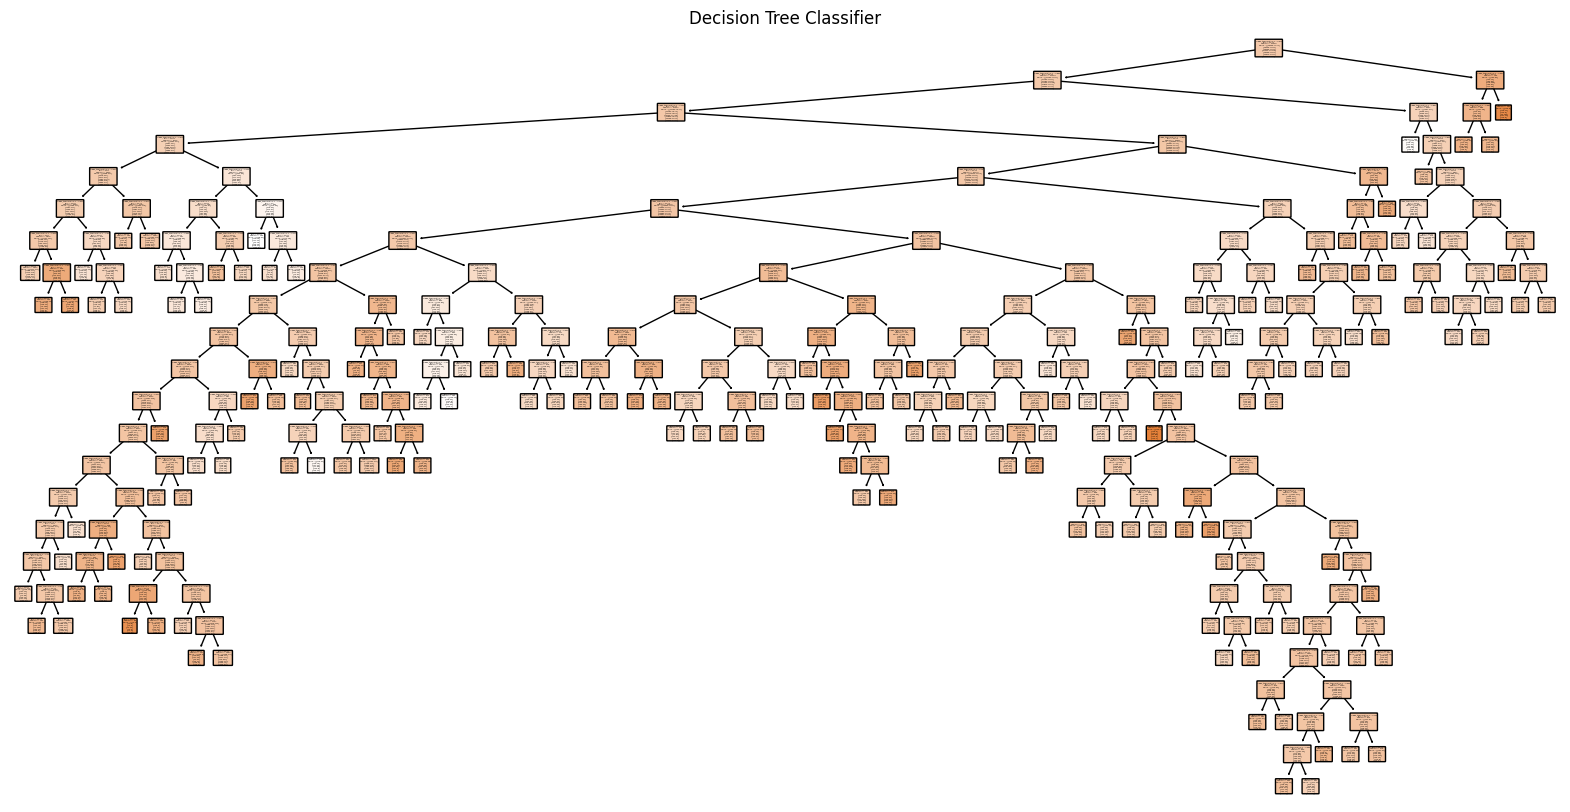

In [228]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=['fridge_temperature', 'temp_condition'], rounded=True)
plt.title("Decision Tree Classifier")
plt.show()

In [229]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f"Classifier Accuracy: {accuracy * 100:.2f}%")

Classifier Accuracy: 57.47%


In [230]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 30, 40], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions
clf_best = grid_search.best_estimator_
y_pred = clf_best.predict(X_test)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


Best parameters found:  {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}


In [231]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Evaluate the classifier
accuracy = accuracy_score(y_test, clf_best.predict(X_test))
precision = precision_score(y_test, clf_best.predict(X_test), average='weighted')
recall = recall_score(y_test, clf_best.predict(X_test), average='weighted')
f1 = f1_score(y_test, clf_best.predict(X_test), average='weighted')

print(f"Classifier Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision* 100:.2f}%")
print(f"Recall: {recall* 100:.2f}%")
print(f"F1-Score: {f1* 100:.2f}%")

Classifier Accuracy: 58.30%
Precision: 33.98%
Recall: 58.30%
F1-Score: 42.94%


c:\Users\Gasper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<module 'matplotlib.pyplot' from 'c:\\Users\\Gasper\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

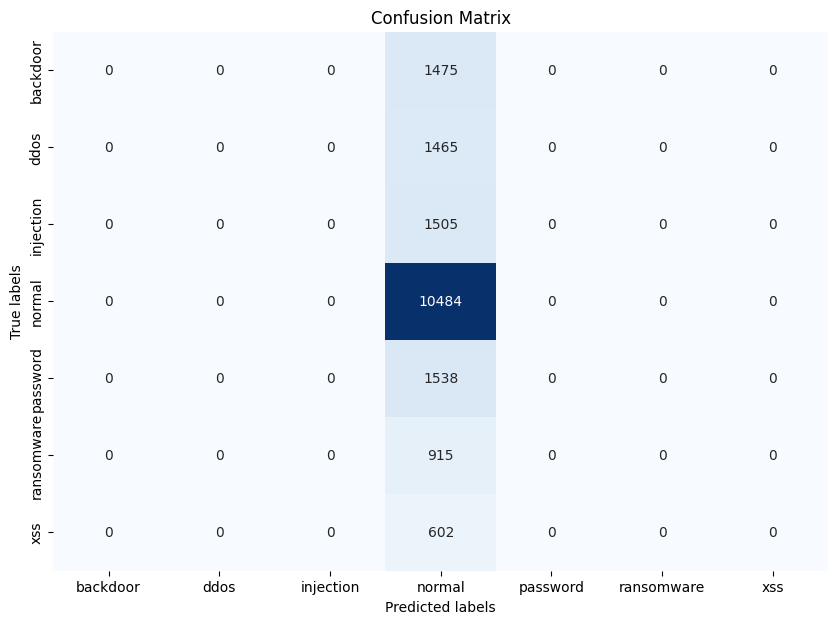

In [232]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert y_pred and y_test from one-hot encoded to label encoded
y_pred_label = np.argmax(y_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_label, y_pred_label)

# Get the unique class labels
classes = [col.replace("type_", "") for col in encoded_columns]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt